In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Wczytywanie i inspekcja danych danych

In [3]:
data = pd.read_stata('HCMST 2017 fresh sample for public sharing draft v1.1.dta')

### Wybrane cechy

#### Ilościowe:
* w6_q21c_year - w którym roku po raz pierwszy zamieszkali ze sobą
* year_fraction_met - rok poznania z uwzględnieniem miesiąca jako ułamka

### Jakościowe:
* hcm2017q24_btwn_I_neighbor - czy są sąsiadami
* w6_otherdate_all - czy w zeszłym roku poznał(a) kogoś poza partnerem

In [23]:
cat_features = ['hcm2017q24_btwn_I_neighbor', 'w6_otherdate_all']
cont_features = ['w6_q21c_year', 'year_fraction_met']
label = 'S1'

## Transformowanie danych

Podstawowe transformowanie danych:
* zamiana wektora y na wektor 0/1 (0 - małżeństwo, 1 - brak małżeństwa)
* zamiana cech kategorycznych na one hot encoding
* usunięcie niedozwolonych przez XGBooost znaków z nazw cech

Sprawdzamy też, czy po usunięciu NaN nie zostało za mało danych.

In [24]:
data = data[cat_features+cont_features+[label]].dropna()
print("Data left: " + str(len(data)))
X = data[cat_features+cont_features].copy()
y = data[label].cat.codes

Data left: 2566


In [28]:
# Convert continuous features to numerics
for cont_feature in cont_features:
    X[cont_feature] = pd.to_numeric(X[cont_feature])
# One hot encoding
X = pd.get_dummies(X)
# Delete unwanted characters
for character in ['[', ']', '<']:
    X.columns = X.columns.str.replace(character, '')

## Trening

Do treningu używam klasyfikatora XGB z domyślnymi parametrami.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [30]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [31]:
print("Accuracy: "+str(accuracy_score(model.predict(X_test), y_test)))

Accuracy: 0.794392523364486


## Zmiana w średniej odpowiedzi modelu

In [126]:
def get_averages(model, X, features_order, obs):
    averages = []
    averages.append(model.predict_proba(X)[:, 1].mean())
    
    column_names = X.columns.values
    
    for feature_name in features_order:
        names_with_prefix = [column_name for column_name in column_names if column_name.startswith(feature_name)]
        for name_with_prefix in names_with_prefix:
            X[name_with_prefix] = obs[name_with_prefix]
        averages.append(model.predict_proba(X)[:, 1].mean())
    
    return averages

In [149]:
def draw_diagram(model, X, features_order, obs):
    averages = get_averages(model, X, features_order, obs)
    print("Średnie po ustaleniu kolejnych zmiennych: " + str(averages))
    plot_data = pd.DataFrame(data = averages, index = ['średnia odp.'] + features_order)[0]
    bottom = plot_data.shift(1).fillna(0)
    plot_data = plot_data-plot_data.shift(1).fillna(0)
    colors = ['r' if x < 0 else 'g' for x in plot_data]
    colors[0] = 'b' # blue for avg. response
    plot = plot_data.plot(kind='bar', stacked = True, bottom = bottom,
                          legend = None, title = "Zmiana w średniej odpowiedzi modelu", color = colors)
    plot.plot()

In [150]:
print("Wyjaśniam obserwację: ")
print(X.loc[1][['w6_q21c_year', 'year_fraction_met']])

Wyjaśniam obserwację: 
w6_q21c_year         1996.000
year_fraction_met    1983.375
Name: 1, dtype: float64


Średnie po ustaleniu kolejnych zmiennych: [0.24039772, 0.21477179, 0.12759852, 0.12759852, 0.12147345]


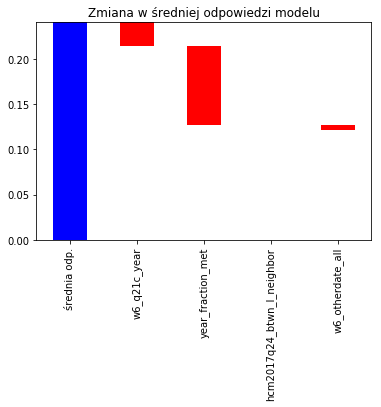

In [151]:
draw_diagram(model, X.copy(), ['w6_q21c_year', 'year_fraction_met', 'hcm2017q24_btwn_I_neighbor', 'w6_otherdate_all'], X.loc[1])

Średnie po ustaleniu kolejnych zmiennych: [0.24039772, 0.24306569, 0.12759852, 0.12759852, 0.12147345]


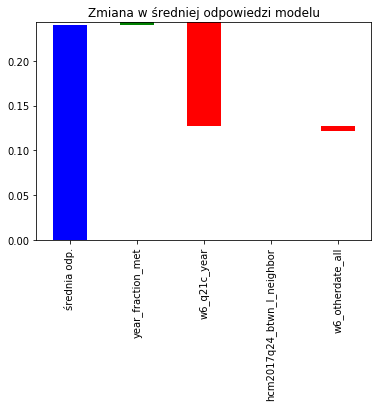

In [152]:
draw_diagram(model, X.copy(), ['year_fraction_met', 'w6_q21c_year', 'hcm2017q24_btwn_I_neighbor', 'w6_otherdate_all'], X.loc[1])

### Opis

W obu wyjaśnieniach zmienna oznaczająca rok pierwszego zamieszkania ze sobą ma duży wpływ na wynik.

W pierwszym wyjaśnieniu zmienna oznaczająca rok poznania ma duży ujemny wpływ na wynik, a w drugim wpływ ten jest praktycznie zerowy. Oznacza to, że  rok poznania (1983) ma znaczenie dopiero jeśli znamy rok pierwszego zamieszkania ze sobą (1996).

Praktycznie zerowy wpływ zmiennej 'hcm2017q24_btwn_I_neighbor' wynika najprawdopodobniej z tego, że tylko dla 2 obserwacji jest ona niezerowa.

In [153]:
X.hcm2017q24_btwn_I_neighbor_yes.sum()

2